In [1]:
!python -V

Python 3.12.7


In [2]:
!ls data

yellow_tripdata_2023-01.parquet  yellow_tripdata_2023-02.parquet


# check number of columns

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_squared_error

In [4]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
print(len(df.columns))

19


In [5]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
print(df['store_and_fwd_flag'].iloc[:10])

0    N
1    N
2    N
3    N
4    N
5    N
6    N
7    N
8    N
9    N
Name: store_and_fwd_flag, dtype: object


In [7]:
# calculate and turn duration to mins
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime #calculate duration
df.duration = df.duration.apply(lambda td: td.total_seconds()/60) #convert it (secs) to mins

# calculate standard deviation of duration

In [8]:
duration_std = np.std(df['duration'])
print(duration_std)

42.5943442974141


# check outlier percentage over the whole dataset

In [9]:
total = len(df) #before dropping outliers
df = df[(df['duration']<=60) & (df['duration']>=1)]
print(len(df)/total)

0.9812202822125979


# one hot encode pickup and dropoff location IDs
PULocationID and DOLocationID

1. Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
   (source: https://saturncloud.io/blog/how-to-convert-dataframe-to-dictionary-in-pandas-without-index/#:~:text=Pandas%20provides%20the%20to_dict(),format%20of%20the%20resulting%20dictionary.)

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)


In [12]:
train_dicts = df[categorical].to_dict(orient = 'records')
#only get three features: PULocationID, DOLocationID and trip_distance
#turn dataframe to a list of dictionaries
print(train_dicts[:10])

[{'PULocationID': '161', 'DOLocationID': '141'}, {'PULocationID': '43', 'DOLocationID': '237'}, {'PULocationID': '48', 'DOLocationID': '238'}, {'PULocationID': '138', 'DOLocationID': '7'}, {'PULocationID': '107', 'DOLocationID': '79'}, {'PULocationID': '161', 'DOLocationID': '137'}, {'PULocationID': '239', 'DOLocationID': '143'}, {'PULocationID': '142', 'DOLocationID': '200'}, {'PULocationID': '164', 'DOLocationID': '236'}, {'PULocationID': '141', 'DOLocationID': '107'}]


In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)#transform a list of dictionaries to a training matrix
print(X_train.shape)

(3009173, 515)


In [59]:
# dv.feature_names_

In [14]:
target = 'duration'
y_train = df[target].values
print(y_train.shape)

(3009173,)


# Train a Linear Regression to predict duration and get RMSE on train set

/tmp/ipykernel_18193/2002317658.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_18193/2002317658.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


<Axes: ylabel='Density'>

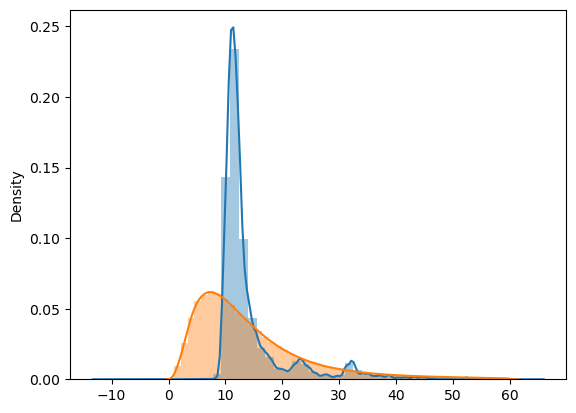

In [15]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_train)

sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [16]:
print(root_mean_squared_error( y_train, y_pred))
print(mean_squared_error( y_train, y_pred, squared=False))

7.64926205038864
7.64926205038864


/home/ubuntu/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
# load validation set 

def read_dataframe(fname):
    df = pd.read_parquet(fname)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime #calculate duration
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60) #convert it (secs) to mins
    
    df = df[(df['duration']<=60) & (df['duration']>=1)]

    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str)
    return df

    

In [35]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')
print(len(df_train), len(df_val))

3009173 2855951


In [38]:
numerical = ['trip_distance']
categorical = ['PULocationID', 'DOLocationID']
target = 'duration'
dv = DictVectorizer()
train_dicts = df_train[categorical+numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values

val_dicts = df_val[categorical+numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3009173, 516) (2855951, 516) (3009173,) (2855951,)


In [39]:
# fit train
lr = LinearRegression().fit(X_train, y_train)
y_hat_train = lr.predict(X_train)

# validate train 
print(mean_squared_error( y_train, y_hat_train, squared=False))

# predict val and validate val
y_pred = lr.predict(X_val)
print(mean_squared_error( y_val, y_pred, squared=False))


7.658406463987032
7.820103694400468


/home/ubuntu/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
